In [ ]:
!module load cuda
!module load cudnn
!echo $CONDA_PREFIX

# Load model architecture and weights, generate and score test predictions

In [ ]:
# REQUIRES NUMPY 1.13, DRAGONN USES NUMPY 1.11.3

from keras.models import model_from_json, model_from_yaml
import json

modelID = "record_2_model_Yjv2n_"

json_path = "../model_files/regressionJun24Positives/" + modelID + "modelJson.json"
with open(json_path) as json_file:
    json_string = json.dumps(json.load(json_file))
    model = model_from_json(json_string)  

model.load_weights("../model_files/regressionJun24Positives/" + modelID + "modelWeights.h5")
    
# plot(model, to_file= "../model_files/plots/" + modelID + "model.png")

# print model.summary()

In [ ]:
import h5py
import numpy as np

with h5py.File('../hdf5files/regressionJun24Positives/test_data.hdf5') as f:
    print f.keys()
    x_data = f['X']
    y_data = f['Y']
    x_test = np.array(x_data['sequence'])
    y_test = np.array(y_data['output'])
    
# y_pred = model.predict(x_test)

In [ ]:
import numpy as np

y_pred = np.genfromtxt('../predictions/regressionJun24Positives_predictions.txt', delimiter='\t')
print y_test.shape
print y_pred.shape

In [ ]:
from scipy.stats import pearsonr, spearmanr
print "Avg signal predictions Pearson = " + str(pearsonr(y_pred[:, 0], y_test[:, 0]))
print "Avg signal predictions Spearman = " + str(spearmanr(y_pred[:, 0], y_test[:, 0]))
print "Rep1 signal predictions Pearson = " + str(pearsonr(y_pred[:, 1], y_test[:, 1]))
print "Rep1 signal predictions Spearman = " + str(spearmanr(y_pred[:, 1], y_test[:, 1]))
print "Rep2 signal predictions Pearson = " + str(pearsonr(y_pred[:, 2], y_test[:, 2]))
print "Rep2 signal predictions Spearman = " + str(spearmanr(y_pred[:, 2], y_test[:, 2]))

# Visualize model conv filters using dragonn.plot

In [1]:
import h5py

modelID = "record_2_model_Yjv2n_"
weightsFileName = "../model_files/regressionJun24Positives/" + modelID + "modelWeights.h5"
weights = h5py.File(weightsFileName, 'r')
print weights.keys()

[u'activation_1', u'activation_2', u'activation_3', u'batchnormalization_1', u'batchnormalization_2', u'batchnormalization_3', u'convolution1d_1', u'convolution1d_2', u'convolution1d_3', u'dense_1', u'dense_2', u'dense_3', u'dropout_1', u'dropout_2', u'flatten_1', u'maxpooling1d_1', u'maxpooling1d_2', u'maxpooling1d_3', u'prelu_1', u'prelu_2']


In [2]:
import numpy as np

layer = 'convolution1d_1'
# print np.array(weights[layer][str(layer + '_W')])
conv1_weights = np.array(weights[layer][str(layer + '_W')])
conv1_biases = np.array(weights[layer][str(layer + '_b')])
print conv1_weights.shape
print conv1_biases.shape
conv1_weights = np.reshape(conv1_weights, (len(conv1_weights), len(conv1_weights[0, 0]), len(conv1_weights[0, 0, 0])))

(19, 1, 4, 300)
(300,)


In [3]:
print conv1_weights.shape
print conv1_weights[:, :, 0]
print np.argmax(conv1_weights[:, :, 0], axis=1)

(19, 4, 300)
[[-0.11128917 -0.03183418  0.06893018 -0.05027375]
 [-0.058998    0.05593267  0.01527301 -0.13465492]
 [-0.03364758 -0.05817579  0.0762761  -0.14522871]
 [-0.00142622  0.05929173 -0.01612915 -0.13250633]
 [-0.01001685  0.04035263 -0.03971431 -0.04443845]
 [-0.17272724 -0.17693767  0.11176802 -0.0687796 ]
 [-0.18243012  0.09310723  0.00456941 -0.16174179]
 [-0.12570705  0.03327686  0.03078664 -0.08654804]
 [-0.09863035  0.02038604  0.05662351 -0.0636117 ]
 [-0.06830868  0.05467101 -0.01422488 -0.03351783]
 [-0.02818692  0.00023157 -0.02520819 -0.00491539]
 [-0.09577488 -0.04957614  0.04777031 -0.02181226]
 [-0.05886953  0.02870095  0.00217359 -0.04959005]
 [-0.10079509  0.00831225  0.00453138 -0.04279199]
 [-0.10833368  0.00759095  0.03939228 -0.07133539]
 [-0.06200105  0.03675932 -0.03286654 -0.00646466]
 [-0.0012678  -0.0793489   0.02360355 -0.00648917]
 [-0.08454371 -0.02397045  0.05448512 -0.03803699]
 [-0.09517875  0.04722301 -0.02352007 -0.05567298]]
[2 1 2 1 1 2 1 1 

/home/users/rmovva/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


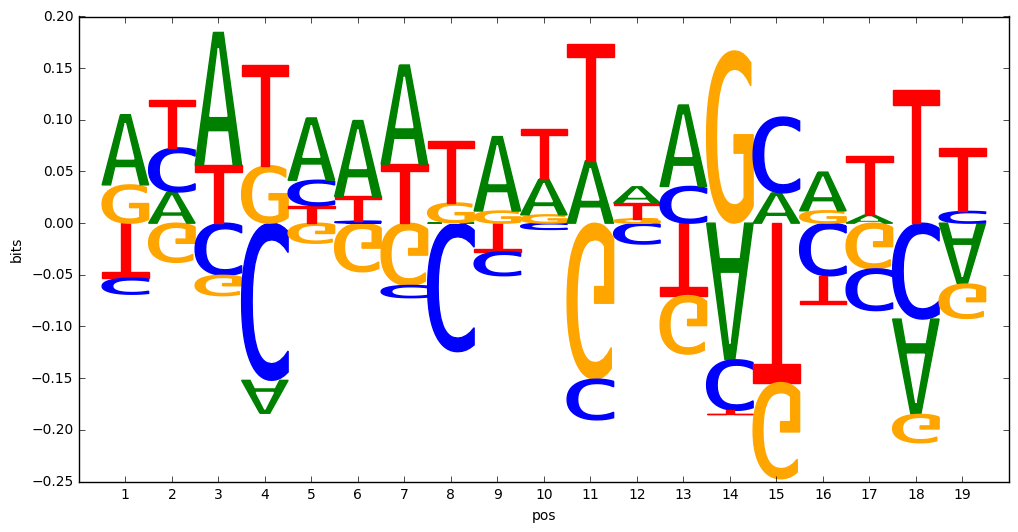

In [4]:
# import matplotlib
# matplotlib.use('Agg')

import matplotlib.pyplot as plt
from dragonn import plot
fig = plot.plot_bases(conv1_weights[:, :, 234])
plt.show()
# fig.savefig('../model_files/regressionJun24Positives/plots/conv1_filter0.png')

In [13]:
def softmax(matrix):
    probs = np.exp(10*matrix[:, :]) / np.repeat(np.reshape(np.sum(np.exp(10*matrix[:, :]), axis = 1), (19, 1, 300)), 4, axis=1)
    return probs

conv_filters_pwms = softmax(conv1_weights)
print conv_filters_pwms.shape
print conv_filters_pwms[:, :, 0]
print np.argmax(conv_filters_pwms[:, :, 0], axis=1)

(19, 4, 300)
[[ 0.08995158  0.19910282  0.54537028  0.16557525]
 [ 0.14865686  0.46916169  0.3124207   0.06976074]
 [ 0.19561788  0.15306781  0.58722025  0.06409407]
 [ 0.25200847  0.46249798  0.21755102  0.06794249]
 [ 0.24350671  0.40296078  0.18094082  0.17259167]
 [ 0.04548091  0.04360572  0.78230536  0.128608  ]
 [ 0.04090813  0.64335859  0.26542282  0.05031041]
 [ 0.08220531  0.40304932  0.39313647  0.12160888]
 [ 0.09587362  0.31519604  0.45285383  0.13607652]
 [ 0.13237873  0.45280609  0.22735326  0.18746188]
 [ 0.21640636  0.28753451  0.22294949  0.27310961]
 [ 0.11256291  0.17866272  0.47293797  0.23583646]
 [ 0.15775289  0.37869632  0.29045859  0.17309223]
 [ 0.11586736  0.34499142  0.33219126  0.20694998]
 [ 0.09983861  0.31823862  0.43738538  0.14453736]
 [ 0.14780666  0.39683032  0.19779877  0.25756419]
 [ 0.27103686  0.1241442   0.34757081  0.25724813]
 [ 0.11847325  0.21711341  0.47578955  0.18862377]
 [ 0.11513206  0.47823274  0.23572518  0.17091006]]
[2 1 2 1 1 2 1 1 

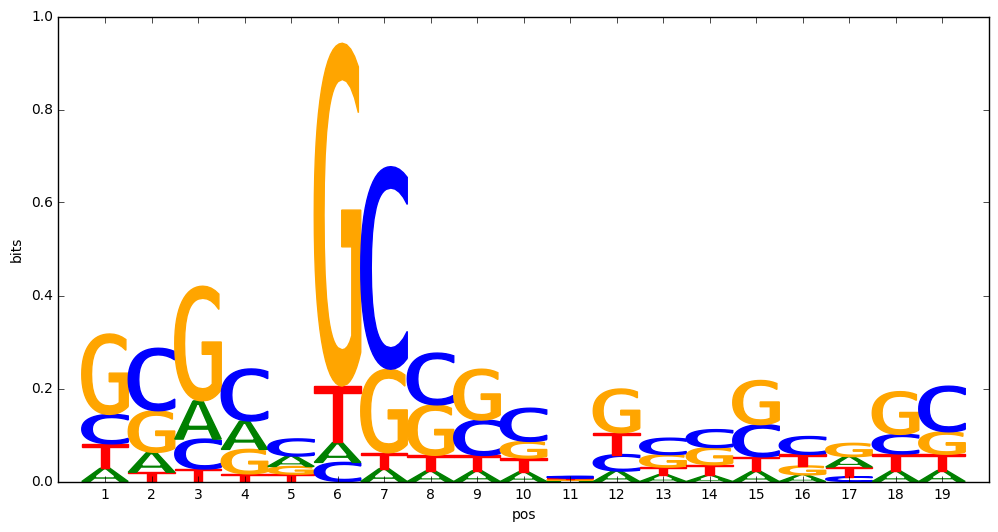

In [17]:
import matplotlib.pyplot as plt
from dragonn import plot
fig = plot.plot_pwm(conv_filters_pwms[:, :, 0])
plt.show()

In [43]:
np.savetxt("../model_files/regressionJun24Positives/interpretation/motifMatrices_conv1.txt",
           conv_filters_pwms[:, :, 0],
           delimiter = '\t',
           fmt = '%s')

In [66]:
def filter_to_sequence(matrix):
    maxedMatrix = np.argmax(conv_filters_pwms, axis = 1)
    bases = {0: 'A', 1: 'C', 2: 'G', 3: 'T'}
    motifMatrix = np.vectorize(bases.get)(maxedMatrix)
    motifMatrix = np.swapaxes(motifMatrix, 0, 1)
    print motifMatrix.shape
    motifs = []
    for arr in motifMatrix:
        arr = list(arr)
        motifs.append(''.join(arr))
    return motifs
    
motifs = filter_to_sequence(conv_filters_pwms)
motifsFile = open('../model_files/regressionJun24Positives/interpretation/conv_filters_transformed_motifs.txt', 'w')
for i in range(len(motifs)):
    motifsFile.write('>conv1_filter' + str(i) + '\n')
    motifsFile.write(motifs[i] + '\n')
motifsFile.close()

(300, 19)


In [22]:
meme = open('../model_files/regressionJun24Positives/interpretation/conv_filters_meme_format.txt', 'w')
meme.write("MEME version 4\n\nALPHABET = ACGT\n\nStrands: + -\n\n" +
           "Background letter frequencies\nA 0.25 C 0.25 G 0.25 T 0.25\n\n")
conv_filter_pwms_reaxis = np.swapaxes(conv_filters_pwms, 0, 2)
conv_filter_pwms_reaxis = np.swapaxes(conv_filter_pwms_reaxis, 1, 2)
for i in range(len(conv_filter_pwms_reaxis)):
# for i in range(2):
    meme.write('MOTIF conv1_filter' + str(i) + '\n')
    meme.write('letter-probability matrix: alength= 4 w= 19\n')
    for j in range(len(conv_filter_pwms_reaxis[i])):
        meme.write(' '.join(conv_filter_pwms_reaxis[i, j].astype(np.str)) + '\n')
    meme.write('\n')

In [64]:
!pwd

/scratch/users/rmovva/mpra/deeplearn/scripts
